<a href="https://colab.research.google.com/github/Juanba98/StableDiffusion/blob/main/StableDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://colab.research.google.com/drive/1_kbRZPTjnFgViPrmGcUsaszEdYa8XTpq?usp=sharing#scrollTo=Mb-u1yDAJ23R

In [2]:
'''
Diffusers provides pretrained diffusion models across multiple modalities, 
such as vision and audio, and serves as a modular toolbox for inference and training of diffusion models.
'''
!pip install diffusers==0.2.4
#Transformers to encode the text
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7, <8"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
from PIL import Image, ImageDraw
import cv2
import numpy as np
from IPython.display import HTML
from base64 import b64encode

import torch
from torch import autocast
from torch.nn import functional as F
from diffusers import StableDiffusionPipeline, AutoencoderKL
from diffusers import UNet2DConditionModel, PNDMScheduler, LMSDiscreteScheduler
from diffusers.schedulers.scheduling_ddim import DDIMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from tqdm.auto import tqdm
from huggingface_hub import notebook_login
from google.colab import output

device = 'cuda'

output.enable_custom_widget_manager()
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [3]:
pipe = StableDiffusionPipeline.from_pretrained(
    'CompVis/stable-diffusion-v1-4', revision='fp16',
    torch_dtype=torch.float16, use_auth_token=True
)
pipe = pipe.to(device)

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/71.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

0it [00:00, ?it/s]

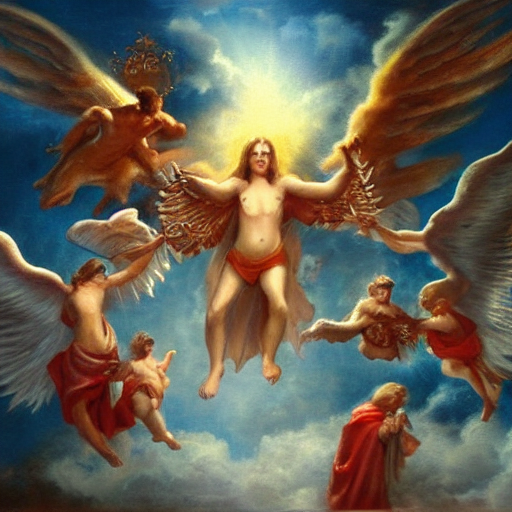

In [7]:
prompt = 'Angels fighting Demons in Heaven'
with autocast(device):
  image = pipe(prompt)['sample'][0]

image

In [9]:
def image_grid (imgs, rows, cols):
  assert len (imgs) == rows*cols

  w, h = imgs [0].size
  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size
  for i, img in enumerate (imgs ) :
    grid.paste (img, box=(i%cols*w, i//cols*h))
  return grid

0it [00:00, ?it/s]

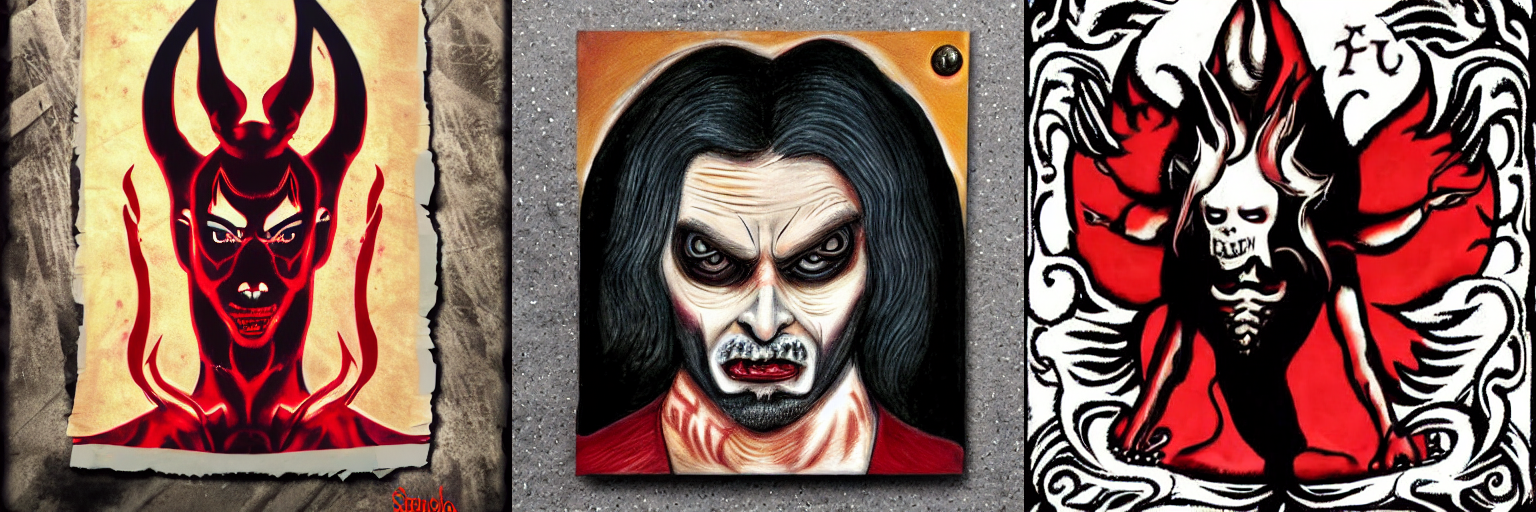

In [11]:
n_images = 3
prompts = ["Satanas"] * n_images
with autocast(device):
    images = pipe(prompts)['sample']

image_grid(images, rows=1, cols=n_images)

# Custom Pipeline

In [7]:
class Pipeline (object):

  def __init__(self):

    # 1. Load the autoencoder model which will be used to decode the latents into image space. 
    vae = AutoencoderKL.from_pretrained(
      'CompVis/stable-diffusion-v1-4', 
      subfolder='vae', 
      use_auth_token=True)
    
    self.vae = vae.to(device)

    # 2. Load the tokenizer and text encoder to tokenize and encode the text. 
    self.tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')
    text_encoder = CLIPTextModel.from_pretrained('openai/clip-vit-large-patch14')
    self.text_encoder = text_encoder.to(device)

    # 3. The UNet model for generating the latents.
    unet = UNet2DConditionModel.from_pretrained(
      'CompVis/stable-diffusion-v1-4', 
      subfolder='unet', 
      use_auth_token=True)
    
    self.unet = unet.to(device)

    # 4. Create a scheduler for inference
    self.scheduler = LMSDiscreteScheduler(
      beta_start=0.00085, 
      beta_end=0.012,
      beta_schedule='scaled_linear', 
      num_train_timesteps=1000)
    

  def __call__ (self,prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, latents=None):
    
    if isinstance(prompts, str):
      prompts = [prompts]

    # Prompts -> text embeds
    text_embeds = self.get_text_embeds(prompts)

    # Text embeds -> img latents
    latents = self.produce_latents(
        text_embeds, height=height, width=width, latents=latents,
        num_inference_steps=num_inference_steps, guidance_scale=guidance_scale)

    # Img latents -> imgs
    imgs = self.decode_img_latents(latents)

    return imgs

  def get_text_embeds(self,prompt):
    # Tokenize text and get embeddings
    text_input = self.tokenizer(
      prompt, 
      padding='max_length', 
      max_length=self.tokenizer.model_max_length,
      truncation=True, 
      return_tensors='pt')
    
    with torch.no_grad():
      text_embeddings = self.text_encoder(text_input.input_ids.to(device))[0]

    # Do the same for unconditional embeddings
    uncond_input = self.tokenizer(
      [''] * len(prompt), padding='max_length',
      max_length=self.tokenizer.model_max_length, 
      return_tensors='pt')
    
    with torch.no_grad():
      uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(device))[0]

    # Cat for final embeddings
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    return text_embeddings


  def produce_latents(self, text_embeddings, height=512, width=512,
                      num_inference_steps=50, guidance_scale=7.5, latents=None):
    if latents is None:
      latents = torch.randn(
          (
              text_embeddings.shape[0] // 2, 
              self.unet.in_channels,
              height // 8, 
              width // 8
          )
        )
      
    latents = latents.to(device)

    self.scheduler.set_timesteps(num_inference_steps)
    latents = latents * self.scheduler.sigmas[0]

    with autocast('cuda'):
      for i, t in tqdm(enumerate(self.scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = self.scheduler.sigmas[i]
        latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

        # predict the noise residual
        with torch.no_grad():
          noise_pred = self.unet(
              latent_model_input, 
              t, 
              encoder_hidden_states=text_embeddings)['sample']

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = self.scheduler.step(noise_pred, i, latents)['prev_sample']
    
    return latents

  def decode_img_latents(self,latents):
    latents = 1 / 0.18215 * latents

    with torch.no_grad():
      imgs = self.vae.decode(latents)

    imgs = (imgs / 2 + 0.5).clamp(0, 1)
    imgs = imgs.detach().cpu().permute(0, 2, 3, 1).numpy()
    imgs = (imgs * 255).round().astype('uint8')
    pil_images = [Image.fromarray(image) for image in imgs]

    return pil_images

## Inicialice

In [9]:
pipeline= Pipeline()

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.14.self_attn.out_proj.weight', 'vision_model.encoder.layers.3.layer_norm1.bias', 'vision_model.encoder.layers.21.self_attn.out_proj.weight', 'vision_model.encoder.layers.7.layer_norm2.weight', 'vision_model.encoder.layers.10.mlp.fc1.weight', 'vision_model.encoder.layers.3.mlp.fc1.weight', 'vision_model.encoder.layers.10.self_attn.v_proj.bias', 'vision_model.encoder.layers.2.self_attn.v_proj.weight', 'vision_model.encoder.layers.2.layer_norm1.weight', 'vision_model.encoder.layers.1.self_attn.k_proj.bias', 'vision_model.encoder.layers.9.self_attn.k_proj.weight', 'vision_model.encoder.layers.19.self_attn.k_proj.weight', 'vision_model.encoder.layers.10.self_attn.k_proj.bias', 'vision_model.encoder.layers.17.self_attn.v_proj.weight', 'vision_model.encoder.layers.22.layer_norm1.bias', 'vision_model.encoder.layers.14.layer_norm1.weight', 'vision_mo

0it [00:00, ?it/s]

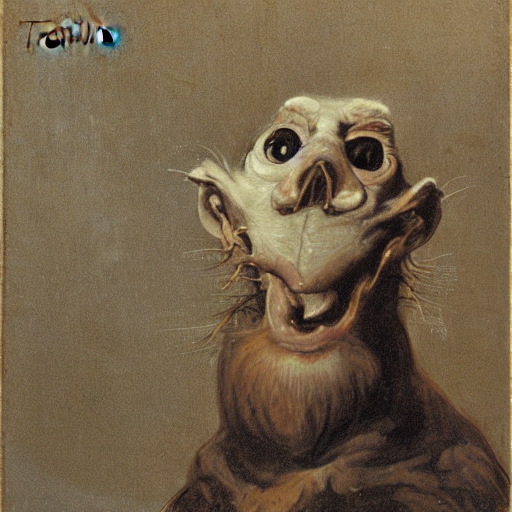

In [10]:
pipeline('Tirade', 512, 512, 50)[0]

#Make a Video

In [ ]:
def produce_latents(text_embeddings, height=512, width=512,
                    num_inference_steps=50, guidance_scale=7.5, latents=None,
                    return_all_latents=False):
  if latents is None:
    latents = torch.randn((text_embeddings.shape[0] // 2, unet.in_channels, \
                           height // 8, width // 8))
  latents = latents.to(device)

  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.sigmas[0]

  latent_hist = [latents]
  with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

      # predict the noise residual
      with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)['sample']

      # perform guidance
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      # compute the previous noisy sample x_t -> x_t-1
      latents = scheduler.step(noise_pred, i, latents)['prev_sample']
      latent_hist.append(latents)
  
  if not return_all_latents:
    return latents

  all_latents = torch.cat(latent_hist, dim=0)
  return all_latents

def prompt_to_img(prompts, height=512, width=512, num_inference_steps=50,
                  guidance_scale=7.5, latents=None, return_all_latents=False,
                  batch_size=2):
  if isinstance(prompts, str):
    prompts = [prompts]

  # Prompts -> text embeds
  text_embeds = get_text_embeds(prompts)

  # Text embeds -> img latents
  latents = produce_latents(
      text_embeds, height=height, width=width, latents=latents,
      num_inference_steps=num_inference_steps, guidance_scale=guidance_scale,
      return_all_latents=return_all_latents)
  
  # Img latents -> imgs
  all_imgs = []
  for i in tqdm(range(0, len(latents), batch_size)):
    imgs = decode_img_latents(latents[i:i+batch_size])
    all_imgs.extend(imgs)

  return all_imgs

In [ ]:
prompt = 'A lighthouse on a cliff from the distance with the rough sea'
video_frames = prompt_to_img(
    prompt, num_inference_steps=50, return_all_latents=True)

0it [00:00, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

In [ ]:
def imgs_to_video(imgs, video_name='video.mp4', fps=15):
  # Source: https://stackoverflow.com/questions/52414148/turn-pil-images-into-video-on-linux
  video_dims = (imgs[0].width, imgs[0].height)
  fourcc = cv2.VideoWriter_fourcc(*'DIVX')    
  video = cv2.VideoWriter(video_name, fourcc, fps, video_dims)
  for img in imgs:
    tmp_img = img.copy()
    video.write(cv2.cvtColor(np.array(tmp_img), cv2.COLOR_RGB2BGR))
  video.release()

def display_video(file_path, width=512):
  compressed_vid_path = 'comp_' + file_path
  if os.path.exists(compressed_vid_path):
    os.remove(compressed_vid_path)
  os.system(f'ffmpeg -i {file_path} -vcodec libx264 {compressed_vid_path}')

  mp4 = open(compressed_vid_path, 'rb').read()
  data_url = 'data:simul2/mp4;base64,' + b64encode(mp4).decode()
  return HTML("""
    <video width={} controls>
          <source src="{}" type="video/mp4">
    </video>
    """.format(width, data_url))

In [ ]:
vid_name = prompt.replace(' ', '_') + '.mp4'
imgs_to_video(video_frames, vid_name,10)
display_video(vid_name)